In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

# from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [4]:
import os
import pandas as pd

train_dir = '../image_compression/ISIC-skin-cancer/Train'
test_dir = '../image_compression/ISIC-skin-cancer/Test'

# Create dataframes
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

# Add images paths and labels to dataframes
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        new_row = [image_path, label]
        train_df.loc[-1] = new_row
        train_df.index = train_df.index + 1
        train_df = train_df.sort_index()

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        new_row = [image_path, label]
        test_df.loc[-1] = new_row
        test_df.index = test_df.index + 1
        test_df = test_df.sort_index()
        
# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

,image_path,label
0,../image_compression/ISIC-skin-cancer/Train/ba...,8
1,../image_compression/ISIC-skin-cancer/Train/ba...,8
2,../image_compression/ISIC-skin-cancer/Train/ba...,8
3,../image_compression/ISIC-skin-cancer/Train/ba...,8
4,../image_compression/ISIC-skin-cancer/Train/ba...,8
...,...,...
2361,../image_compression/ISIC-skin-cancer/Test/act...,0
2362,../image_compression/ISIC-skin-cancer/Test/act...,0
2363,../image_compression/ISIC-skin-cancer/Test/act...,0
2364,../image_compression/ISIC-skin-cancer/Test/act...,0


In [5]:
filter = df['image_path'].str.contains("decompressed")
df = df[~filter]
df

,image_path,label
0,../image_compression/ISIC-skin-cancer/Train/ba...,8
1,../image_compression/ISIC-skin-cancer/Train/ba...,8
2,../image_compression/ISIC-skin-cancer/Train/ba...,8
3,../image_compression/ISIC-skin-cancer/Train/ba...,8
4,../image_compression/ISIC-skin-cancer/Train/ba...,8
...,...,...
2361,../image_compression/ISIC-skin-cancer/Test/act...,0
2362,../image_compression/ISIC-skin-cancer/Test/act...,0
2363,../image_compression/ISIC-skin-cancer/Test/act...,0
2364,../image_compression/ISIC-skin-cancer/Test/act...,0


In [6]:
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'seborrheic keratosis',
 2: 'melanoma',
 3: 'dermatofibroma',
 4: 'pigmented benign keratosis',
 5: 'vascular lesion',
 6: 'squamous cell carcinoma',
 7: 'nevus',
 8: 'basal cell carcinoma'}

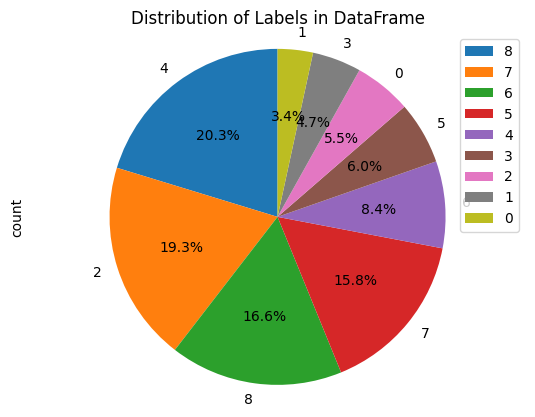

In [7]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [8]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               seborrheic keratosis           80        
2               melanoma                       454       
3               dermatofibroma                 111       
4               pigmented benign keratosis     478       
5               vascular lesion                142       
6               squamous cell carcinoma        197       
7               nevus                          373       
8               basal cell carcinoma           392       
------------------------------------------------------------
Total                                         2357      


In [9]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

In [10]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


2025-03-13 09:54:41.319286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-13 09:54:41.319734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-03-13 09:54:41.320079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-03-13 09:54:41.320418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2025-03-13 09:54:41.543671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [11]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

96

In [12]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

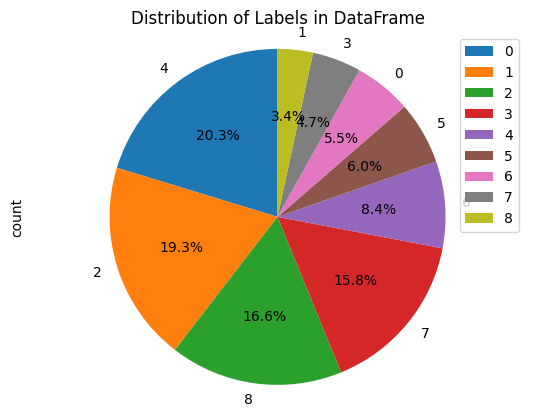

In [13]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [14]:
df.head()


,image_path,label,image
0,../image_compression/ISIC-skin-cancer/Train/ac...,0,"[[[128, 98, 106], [133, 108, 114], [137, 113, ..."
1,../image_compression/ISIC-skin-cancer/Train/ac...,0,"[[[187, 123, 145], [185, 114, 144], [187, 117,..."
2,../image_compression/ISIC-skin-cancer/Train/ac...,0,"[[[160, 132, 127], [160, 127, 122], [161, 126,..."
3,../image_compression/ISIC-skin-cancer/Train/ac...,0,"[[[109, 76, 66], [114, 81, 75], [120, 87, 79],..."
4,../image_compression/ISIC-skin-cancer/Train/ac...,0,"[[[143, 96, 106], [146, 101, 111], [154, 112, ..."


In [15]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               seborrheic keratosis           80        
2               melanoma                       454       
3               dermatofibroma                 111       
4               pigmented benign keratosis     478       
5               vascular lesion                142       
6               squamous cell carcinoma        197       
7               nevus                          373       
8               basal cell carcinoma           392       
------------------------------------------------------------
Total                                         2357      


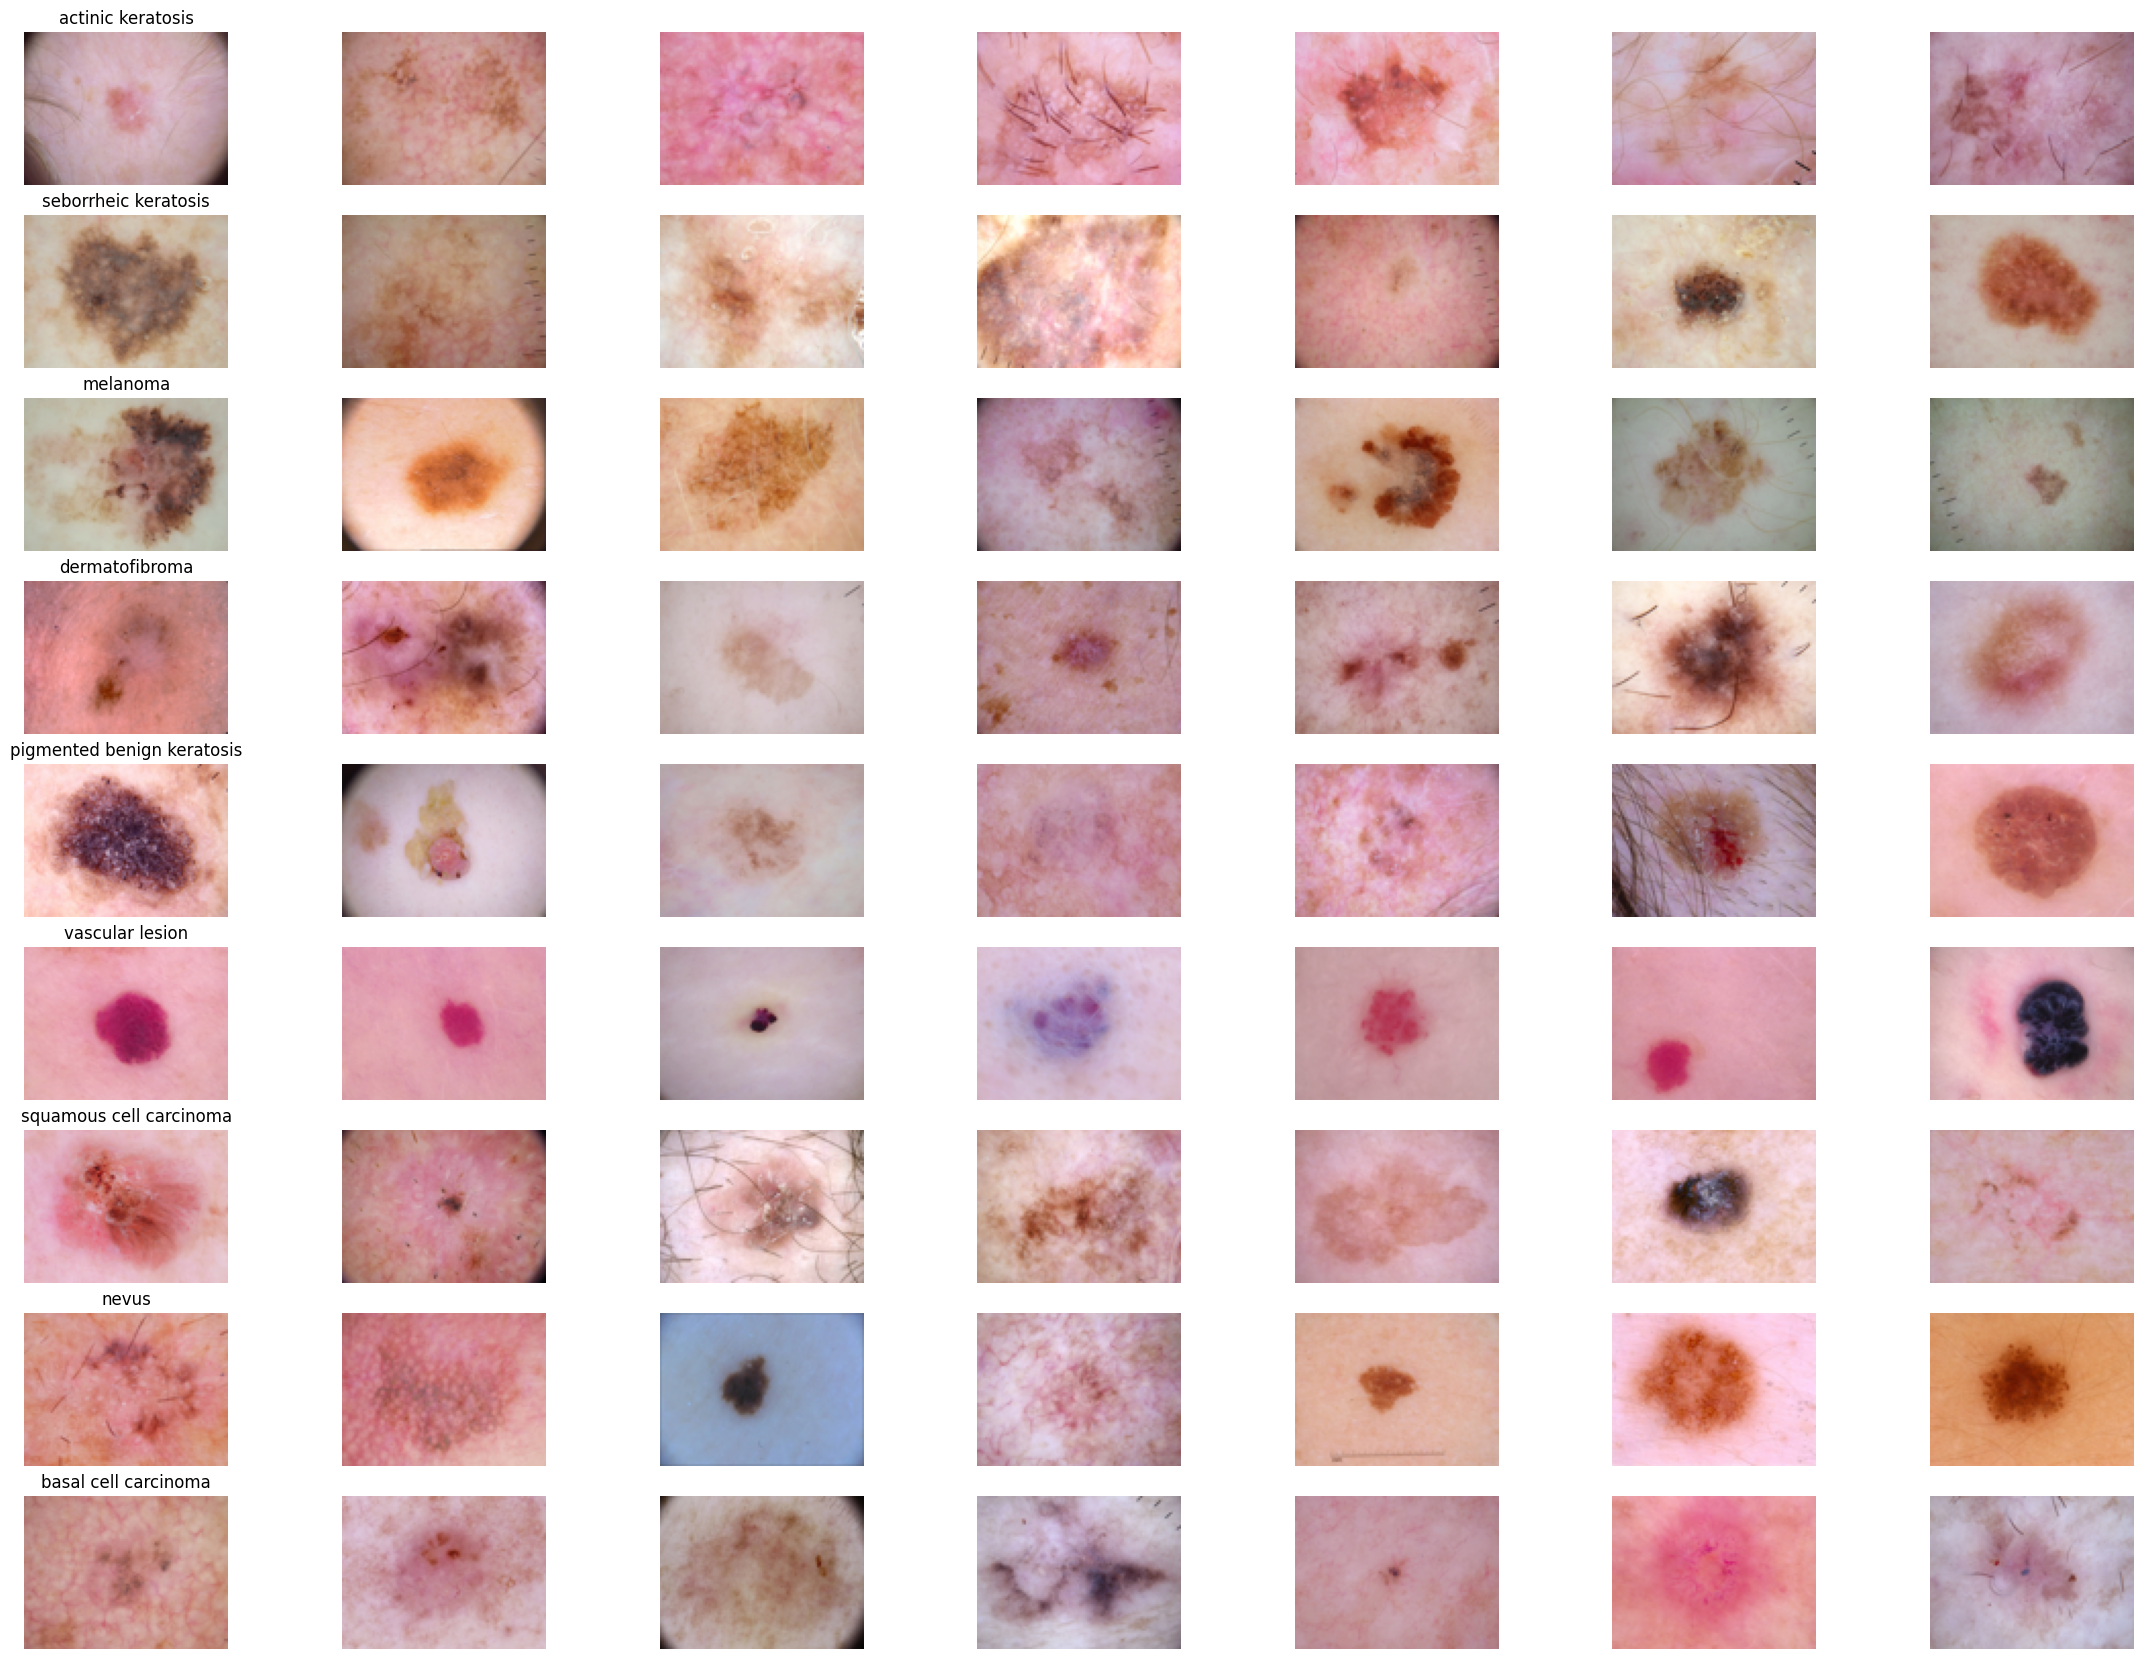

In [16]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [17]:
df['image'].map(lambda x: x.shape).value_counts()


image
(75, 100, 3)    2357
Name: count, dtype: int64

In [18]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [19]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                new_row = [None, class_label, augmented_image_array]
                augmented_df.loc[-1] = new_row
                augmented_df.index = augmented_df.index + 1
                augmented_df = augmented_df.sort_index()
    
    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = pd.concat([augmented_df, original_images_df])

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              2500      
1               seborrheic keratosis           2500      
2               melanoma                       2500      
3               dermatofibroma                 2500      
4               pigmented benign keratosis     2500      
5               vascular lesion                2500      
6               squamous cell carcinoma        2500      
7               nevus                          2500      
8               basal cell carcinoma           2500      
------------------------------------------------------------
Total                                         22500     


In [21]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [22]:
features.head()

,image
0,"[[[171, 124, 133], [168, 121, 129], [167, 121,..."
1,"[[[137, 103, 107], [137, 103, 107], [137, 103,..."
2,"[[[199, 195, 180], [200, 197, 181], [200, 196,..."
3,"[[[231, 190, 209], [231, 191, 210], [232, 191,..."
4,"[[[73, 75, 88], [73, 75, 88], [73, 75, 88], [7..."


In [23]:
target.head()


0    7
1    5
2    1
3    5
4    4
Name: label, dtype: int64

In [24]:
print(target.shape,features.shape)


(22500,) (22500, 1)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)


In [26]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [27]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [28]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [29]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [30]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [31]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               actinic keratosis              1595       390          515        2500      
1               seborrheic keratosis           1612       390          498        2500      
2               melanoma                       1585       438          477        2500      
3               dermatofibroma                 1628       381          491        2500      
4               pigmented benign keratosis     1561       402          537        2500      
5               vascular lesion                1624       409          467        2500      
6               squamous cell carcinoma        1599       406          495        2500      
7               nevus                          1616       

In [32]:
df.groupby('label').size()


label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [33]:
input_shape = df['image'][0].shape


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DenseNet201 Model
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomDenseNet, self).__init__()
        self.densenet = models.densenet201(pretrained=True)
        
        # Remove the classification head
        self.densenet = nn.Sequential(*list(self.densenet.children())[:-1])
        
        # Define new classification head
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(11520, 512)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.densenet(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

# Set input size and number of classes
model = CustomDenseNet(num_classes=10).to(device)

/workspace/user/user6/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/user/user6/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-5)

/workspace/user/user6/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [37]:
print(device)

cuda


In [38]:
# Load Data 
batch_size = 32

def numpy_to_torchloader(x, y, batch_size):
    tensor_x = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to PyTorch format (N, C, H, W)
    tensor_y = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = numpy_to_torchloader(x_train, np.argmax(y_train, axis=1), batch_size)
val_loader = numpy_to_torchloader(x_validate, np.argmax(y_validate, axis=1), batch_size)
test_loader = numpy_to_torchloader(x_test, np.argmax(y_test, axis=1), batch_size)

# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {train_acc:.4f}")

    # Validation step
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_acc = correct / total
    scheduler.step(val_acc)  # Adjust learning rate
    print(f"Validation Accuracy: {val_acc:.4f}")

Epoch 1/50 - Loss: 2.1069 - Accuracy: 0.3870
Validation Accuracy: 0.5675
Epoch 2/50 - Loss: 1.8165 - Accuracy: 0.6669
Validation Accuracy: 0.7292
Epoch 3/50 - Loss: 1.6984 - Accuracy: 0.7792
Validation Accuracy: 0.7919
Epoch 4/50 - Loss: 1.6315 - Accuracy: 0.8436
Validation Accuracy: 0.8164
Epoch 5/50 - Loss: 1.5908 - Accuracy: 0.8803
Validation Accuracy: 0.8517
Epoch 6/50 - Loss: 1.5662 - Accuracy: 0.9021
Validation Accuracy: 0.8575
Epoch 7/50 - Loss: 1.5534 - Accuracy: 0.9128
Validation Accuracy: 0.8689
Epoch 8/50 - Loss: 1.5388 - Accuracy: 0.9268
Validation Accuracy: 0.8758
Epoch 9/50 - Loss: 1.5319 - Accuracy: 0.9328
Validation Accuracy: 0.8822
Epoch 10/50 - Loss: 1.5271 - Accuracy: 0.9374
Validation Accuracy: 0.8992
Epoch 11/50 - Loss: 1.5200 - Accuracy: 0.9440
Validation Accuracy: 0.8944
Epoch 12/50 - Loss: 1.5168 - Accuracy: 0.9474
Validation Accuracy: 0.8981
Epoch 13/50 - Loss: 1.5159 - Accuracy: 0.9471
Validation Accuracy: 0.8978
Epoch 14/50 - Loss: 1.5119 - Accuracy: 0.9519
V

In [39]:
# Evaluate on Train and Test sets
def evaluate(loader, dataset_name="Test"):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    print(f"{dataset_name}: Accuracy = {acc:.4f}")
    return np.array(all_labels), np.array(all_preds)

# Get results
y_train_true, y_train_pred = evaluate(train_loader, "Train")
y_test_true, y_test_pred = evaluate(test_loader, "Test")

Train: Accuracy = 0.9680
Test: Accuracy = 0.9213


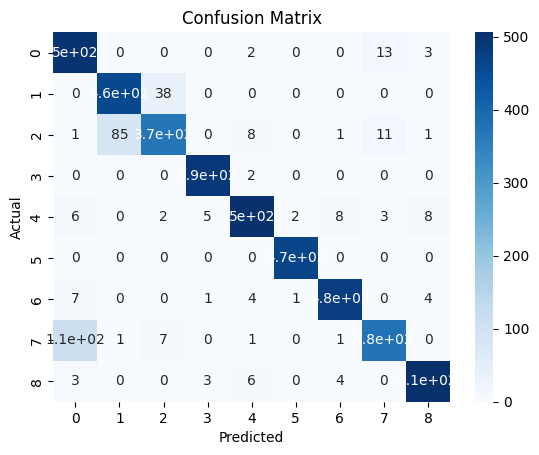

In [40]:
# Compute Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [41]:
# Compute Evaluation Metrics
accuracy = accuracy_score(y_test_true, y_test_pred)
precision = precision_score(y_test_true, y_test_pred, average='macro')
recall = recall_score(y_test_true, y_test_pred, average='macro')
f1 = f1_score(y_test_true, y_test_pred, average='macro')
kappa = cohen_kappa_score(y_test_true, y_test_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.9213
Precision: 0.9255
Recall: 0.9208
F1-score: 0.9205
Kappa score: 0.9115


In [42]:
torch.save(model, "densenet201_clf.pth")

In [43]:
torch.save(model.state_dict(), "densenet201_clf_state_dict.pth")

In [45]:
clf_model = CustomDenseNet(num_classes=10)
clf_model.load_state_dict(torch.load("densenet201_clf_state_dict.pth"))

/tmp/ipykernel_1548/1093639472.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clf_model.load_state_dict(torch.load("densenet201_clf_state_dict.pth"))


<All keys matched successfully>

cheng2020_anchor_1: Accuracy = 0.7627
Accuracy: 0.7627
Precision: 0.8627
Recall: 0.8056
F1-score: 0.7903
Kappa score: 0.7273


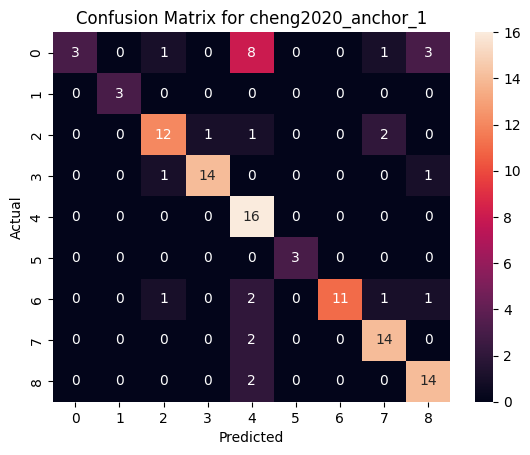

cheng2020_attn_1: Accuracy = 0.7542
Accuracy: 0.7542
Precision: 0.8658
Recall: 0.7986
F1-score: 0.7914
Kappa score: 0.7175


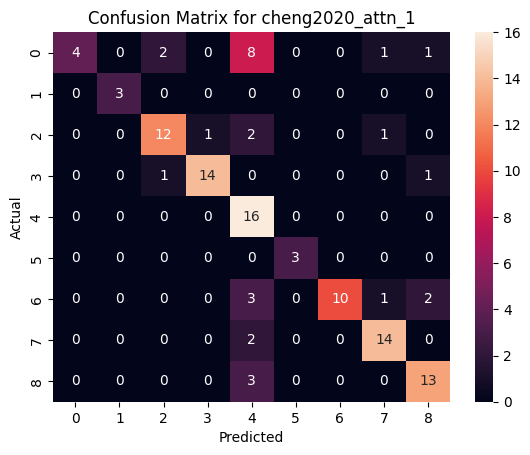

cheng2020_anchor_3: Accuracy = 0.7542
Accuracy: 0.7542
Precision: 0.8242
Recall: 0.7685
F1-score: 0.7582
Kappa score: 0.7175


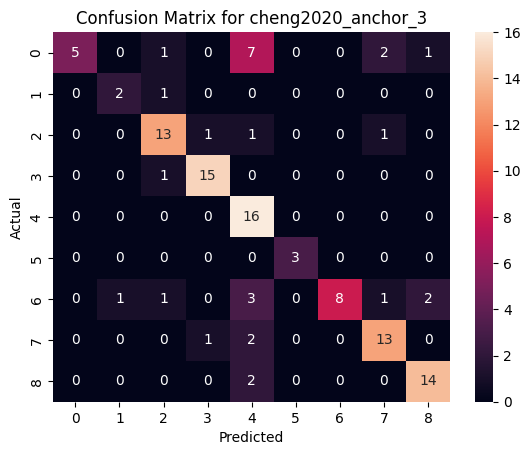

cheng2020_attn_3: Accuracy = 0.7288
Accuracy: 0.7288
Precision: 0.7768
Recall: 0.7477
F1-score: 0.7071
Kappa score: 0.6890


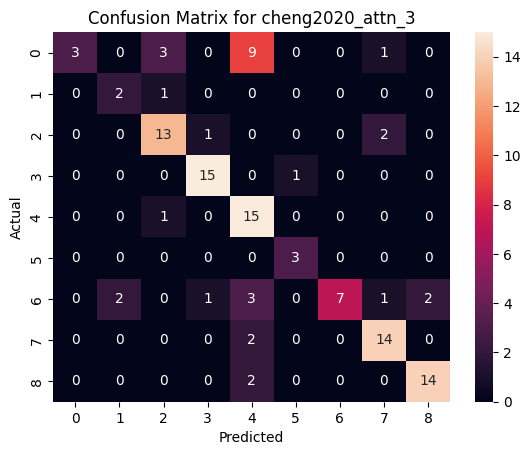

cheng2020_anchor_6: Accuracy = 0.7797
Accuracy: 0.7797
Precision: 0.8295
Recall: 0.7894
F1-score: 0.7814
Kappa score: 0.7467


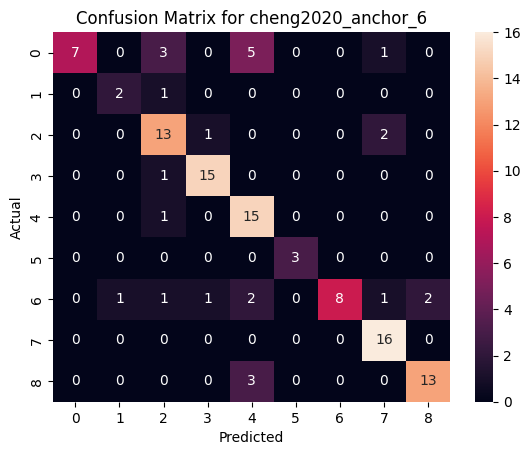

cheng2020_attn_6: Accuracy = 0.7797
Accuracy: 0.7797
Precision: 0.8317
Recall: 0.7894
F1-score: 0.7788
Kappa score: 0.7467


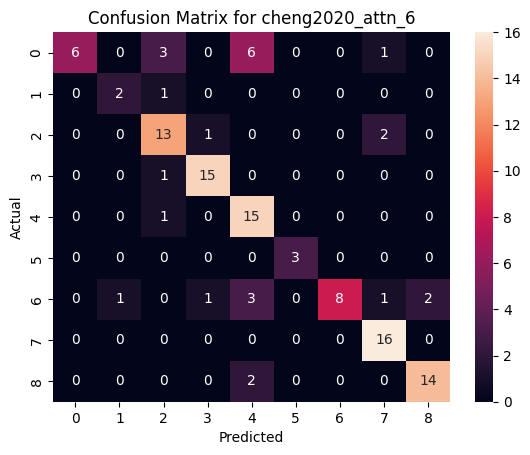

In [89]:
decomp_test_dir = '../image_compression/ISIC-skin-cancer/Test'
decomp_model_list = ["cheng2020_anchor_1", "cheng2020_attn_1",
                     # "cheng2020_anchor_2", "cheng2020_attn_2",
                     "cheng2020_anchor_3", "cheng2020_attn_3",
                     # "cheng2020_anchor_4", "cheng2020_attn_4",
                     # "cheng2020_anchor_5", "cheng2020_attn_5",
                     "cheng2020_anchor_6", "cheng2020_attn_6"]

# Create dataframes
df = pd.DataFrame(columns=['image_path', 'label'])

for decomp_model in decomp_model_list:
    df = pd.DataFrame(columns=['image_path', 'label'])
    
    for label, directory in enumerate(os.listdir(decomp_test_dir)):
        for filename in os.listdir(os.path.join(decomp_test_dir, directory, "decompressed", decomp_model)):
            image_path = os.path.join(decomp_test_dir, directory, "decompressed", decomp_model, filename)
            new_row = [image_path, label]
            df.loc[-1] = new_row
            df.index = df.index + 1
            df = df.sort_index()

    # Use concurrent.futures to parallelize the resizing process
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Use executor.map to apply the function to each image path in the DataFrame
        image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))
            
    # Add the resized image arrays to the DataFrame
    df['image'] = image_arrays
    del image_arrays
            
    features = df.drop(columns=['label','image_path'],axis=1)
    target = df['label']

    features = np.asarray(features['image'].tolist())
    features_mean = np.mean(features)
    features_std = np.std(features)
    features = (features - features_mean)/features_std
    features = features.reshape(features.shape[0], *(75, 100, 3))

    target = to_categorical(target,num_classes = num_classes)
    decomp_test_loader = numpy_to_torchloader(features, np.argmax(target, axis=1), batch_size)
    true_label, pred_label = evaluate(decomp_test_loader, f"{decomp_model}")

    # Compute Evaluation Metrics
    accuracy = accuracy_score(true_label, pred_label)
    precision = precision_score(true_label, pred_label, average='macro')
    recall = recall_score(true_label, pred_label, average='macro')
    f1 = f1_score(true_label, pred_label, average='macro')
    kappa = cohen_kappa_score(true_label, pred_label)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Kappa score: {kappa:.4f}")
    cm = confusion_matrix(true_label, pred_label)
    sns.heatmap(cm, annot=True)
    plt.title(f"Confusion Matrix for {decomp_model}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [64]:
y_test_true, y_test_pred = evaluate(test_loader, "Test")

Test: Accuracy = 0.9213


In [66]:
label_map

{0: 'actinic keratosis',
 1: 'seborrheic keratosis',
 2: 'melanoma',
 3: 'dermatofibroma',
 4: 'pigmented benign keratosis',
 5: 'vascular lesion',
 6: 'squamous cell carcinoma',
 7: 'nevus',
 8: 'basal cell carcinoma'}

Test_no_aug: Accuracy = 0.9492
Accuracy: 0.9492
Precision: 0.9624
Recall: 0.9282
F1-score: 0.9398
Kappa score: 0.9415


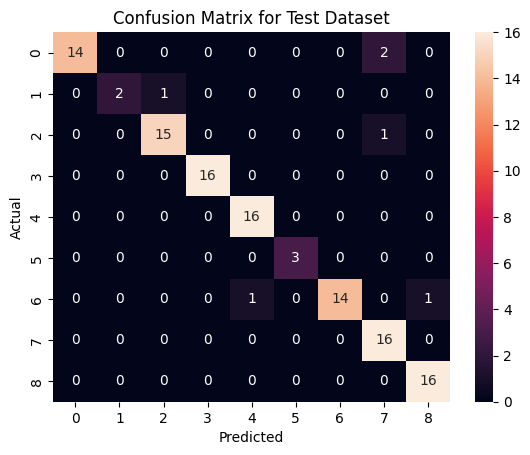

In [90]:
test_dir = '../image_compression/ISIC-skin-cancer/Test'

test_no_aug_df = pd.DataFrame(columns=['image_path', 'label'])

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        new_row = [image_path, label]
        test_no_aug_df.loc[-1] = new_row
        test_no_aug_df.index = test_no_aug_df.index + 1
        test_no_aug_df = test_no_aug_df.sort_index()

filter = test_no_aug_df['image_path'].str.contains("decompressed")
test_no_aug_df = test_no_aug_df[~filter]

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, test_no_aug_df['image_path'].tolist()))
            
    # Add the resized image arrays to the DataFrame
test_no_aug_df['image'] = image_arrays
del image_arrays

features = test_no_aug_df.drop(columns=['label','image_path'],axis=1)
target = test_no_aug_df['label']

features = np.asarray(features['image'].tolist())
features_mean = np.mean(features)
features_std = np.std(features)
features = (features - features_mean)/features_std
features = features.reshape(features.shape[0], *(75, 100, 3))

target = to_categorical(target,num_classes = num_classes)
decomp_test_loader = numpy_to_torchloader(features, np.argmax(target, axis=1), batch_size)
true_label, pred_label = evaluate(decomp_test_loader, "Test_no_aug")

# Compute Evaluation Metrics
accuracy = accuracy_score(true_label, pred_label)
precision = precision_score(true_label, pred_label, average='macro')
recall = recall_score(true_label, pred_label, average='macro')
f1 = f1_score(true_label, pred_label, average='macro')
kappa = cohen_kappa_score(true_label, pred_label)
    
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")
cm = confusion_matrix(true_label, pred_label)
sns.heatmap(cm, annot=True)
plt.title(f"Confusion Matrix for Test Dataset")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()